# Mechanisms of Action (MoA) Prediction:
***
![image1](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F846065%2F283d7731734a680ad0abe9579059dacc%2FNew%20Project.png?generation=1600472356251411&alt=media)

In this competition, we are supposed to develop models **to determine the mechanism of action of a new drug based on the gene expression and cell viability information.** For this competition, you will have access to a unique dataset that combines gene expression and cell viability data in addition to the MoA annotations of more than 5,000 drugs.
<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">PROJECT CONTENT</h3>
    
> ####  1- Exploratory Data Analysis
> ####  2- Feature Engineering
> ####  3. Models Ensemble
    
## If you find this kernel useful, Please Upvote it , it motivates me to write more Quality content :)    

## **Objective and Metric:**

This is a multi-label binary classification problem, and metric used for the evaluation is mean columnwise log loss. For every row, a probability that the sample had a positive response for each target, has to be predicted. For $N$ rows and $M$ targets, there will be $N×M$ predictions. Submissions are scored by the log loss:

$\Large \text{log loss} = - \frac{1}{M}\sum_{m=1}^{M} \frac{1}{N} \sum_{i=1}^{N} \left[ y_{i,m} \log(\hat{y}_{i,m}) + (1 - y_{i,m}) \log(1 - \hat{y}_{i,m})\right]$

* $N$ is the number of rows ($i=1,…,N$)
* $M$ is the number of targets ($m=1,…,M$)
* $\large \hat{y}_{i,m}$ is the predicted probability of the ith row and mth target
* $\large y_{i,m}$ is the ground truth of the ith row and mth target (1 for a positive response, 0 otherwise)
* $log()$ is the natural logarithm

Submitted predicted probabilities are replaced with $max(min(p,1-10^{-15}),10^{-15})$.
***
## Importing Necesseties:

In [1]:
!pip install --no-index --find-links /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl pytorch-tabnet

Looking in links: /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl
Processing /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl


In [2]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
import os
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from pickle import load,dump

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

## Reading data:

In [4]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
train_drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [5]:
#Just making a copy of train and test features
train_features2=train_features.copy()
test_features2=test_features.copy()

># Exploartory Data Analysis:
># Overview: Features
* Features **g-** signify gene expression data.
* Features **c-** signify cell viability data.
* **cp_type** indicates samples treated with a compound, **trt_cp** samples treated with the compounds. 
* **cp_vehicle** or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs.
* **cp_time** and **cp_dose** indicate treatment duration (24, 48, 72 hours) and dose (high or low).

**Let's have a quick glance at Train Features**

In [6]:
print('Training Features Samples')
display(train_features.head(3))
print('Training Features Description')
display(train_features.describe())

Training Features Samples


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  

[3 rows x 876 columns]

Training Features Description


cp_time           g-0           g-1           g-2           g-3  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      48.020156      0.248366     -0.095684      0.152253      0.081971   
std       19.402807      1.393399      0.812363      1.035731      0.950012   
min       24.000000     -5.513000     -5.737000     -9.104000     -5.998000   
25%       24.000000     -0.473075     -0.562200     -0.437750     -0.429575   
50%       48.000000     -0.008850     -0.046600      0.075200      0.008050   
75%       72.000000      0.525700      0.403075      0.663925      0.463400   
max       72.000000     10.000000      5.039000      8.257000     10.000000   

                g-4           g-5           g-6           g-7           g-8  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean       0.057347     -0.138836      0.035961     -0.202651     -0.190083   
std        1.032091      1.179388      0.882395      1.125494      1.749885   
min       -6.369000    -10.000000    -10.000000    -10.000000    -10.000000   
25%       -0.470925     -0.602225     -0.493900     -0.525175     -0.511675   
50%       -0.026900     -0.015650     -0.000650     -0.017900      0.010000   
75%        0.465375      0.510425      0.528725      0.411900      0.549225   
max       10.000000      7.282000      7.333000      5.473000      8.887000   

       ...          c-90          c-91          c-92          c-93  \
count  ...  23814.000000  23814.000000  23814.000000  23814.000000   
mean   ...     -0.469244     -0.461411     -0.513256     -0.500142   
std    ...      2.000488      2.042475      2.001714      2.107105   
min    ...    -10.000000    -10.000000    -10.000000    -10.000000   
25%    ...     -0.566175     -0.565975     -0.589975     -0.568700   
50%    ...     -0.009900      0.003250     -0.009100     -0.013750   
75%    ...      0.457750      0.461500      0.445675      0.452900   
max    ...      4.069000      3.960000      3.927000      3.596000   

               c-94          c-95          c-96          c-97          c-98  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      -0.507093     -0.353726     -0.463485     -0.378241     -0.470252   
std        2.159589      1.629291      2.059725      1.703615      1.834828   
min      -10.000000    -10.000000    -10.000000    -10.000000    -10.000000   
25%       -0.563775     -0.567975     -0.552575     -0.561000     -0.592600   
50%       -0.003300     -0.010250     -0.001250     -0.006800      0.014000   
75%        0.470900      0.444750      0.465225      0.446400      0.461275   
max        3.747000      2.814000      3.505000      2.924000      3.111000   

               c-99  
count  23814.000000  
mean      -0.301505  
std        1.407918  
min      -10.000000  
25%       -0.562900  
50%       -0.019500  
75%        0.438650  
max        3.805000  

[8 rows x 873 columns]

**Let's have a quick glance at Test Features**

In [7]:
print('Training Features Samples')
display(test_features.head(3))
print('Training Features Description')
display(test_features.describe())

Training Features Samples


sig_id      cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_0004d9e33       trt_cp       24      D1 -0.5458  0.1306 -0.5135  0.4408   
1  id_001897cda       trt_cp       72      D1 -0.1829  0.2320  1.2080 -0.4522   
2  id_002429b5b  ctl_vehicle       24      D1  0.1852 -0.1404 -0.3911  0.1310   

      g-4     g-5  ...    c-90    c-91   c-92    c-93    c-94    c-95    c-96  \
0  1.5500 -0.1644  ...  0.0981  0.7978 -0.143 -0.2067 -0.2303 -0.1193  0.0210   
1 -0.3652 -0.3319  ... -0.1190 -0.1852 -1.031 -1.3670 -0.3690 -0.5382  0.0359   
2 -1.4380  0.2455  ... -0.2261  0.3370 -1.384  0.8604 -1.9530 -1.0140  0.8662   

     c-97    c-98    c-99  
0 -0.0502  0.1510 -0.7750  
1 -0.4764 -1.3810 -0.7300  
2  1.0160  0.4924 -0.1942  

[3 rows x 876 columns]

Training Features Description


cp_time          g-0          g-1          g-2          g-3  \
count  3982.000000  3982.000000  3982.000000  3982.000000  3982.000000   
mean     48.030136     0.197471    -0.063233     0.137516     0.049622   
std      19.414155     1.373476     0.800573     1.066475     0.949972   
min      24.000000    -5.321000    -4.142000    -6.996000    -3.765000   
25%      24.000000    -0.502725    -0.552975    -0.431800    -0.465350   
50%      48.000000    -0.060700    -0.027500     0.073400    -0.036450   
75%      72.000000     0.454650     0.429950     0.641125     0.423150   
max      72.000000    10.000000     4.536000     8.227000    10.000000   

               g-4          g-5          g-6          g-7          g-8  ...  \
count  3982.000000  3982.000000  3982.000000  3982.000000  3982.000000  ...   
mean      0.052434    -0.147852     0.010424    -0.166886    -0.168069  ...   
std       0.994018     1.204934     0.859452     1.088335     1.666240  ...   
min      -6.312000    -8.717000    -6.037000    -8.833000   -10.000000  ...   
25%      -0.445750    -0.576000    -0.521325    -0.477400    -0.526925  ...   
50%      -0.047800    -0.012500    -0.009200     0.002150    -0.002900  ...   
75%       0.436050     0.498950     0.495975     0.422500     0.518050  ...   
max       7.615000     6.356000     6.190000     2.995000     8.007000  ...   

              c-90         c-91         c-92         c-93         c-94  \
count  3982.000000  3982.000000  3982.000000  3982.000000  3982.000000   
mean     -0.429980    -0.413215    -0.475762    -0.462484    -0.479196   
std       2.013142     1.995433     1.963440     2.128477     2.149705   
min     -10.000000   -10.000000   -10.000000   -10.000000   -10.000000   
25%      -0.527725    -0.521850    -0.539375    -0.540450    -0.548175   
50%       0.010050     0.010900     0.006550     0.017500     0.013450   
75%       0.478900     0.479625     0.442550     0.473300     0.487825   
max       4.936000     5.300000     3.268000     4.087000     5.290000   

              c-95         c-96         c-97         c-98         c-99  
count  3982.000000  3982.000000  3982.000000  3982.000000  3982.000000  
mean     -0.346450    -0.423905    -0.316387    -0.404859    -0.269792  
std       1.645669     2.086895     1.655524     1.790883     1.355936  
min     -10.000000   -10.000000   -10.000000   -10.000000   -10.000000  
25%      -0.561525    -0.497050    -0.521125    -0.531075    -0.541950  
50%      -0.020000     0.043800     0.020450     0.030750    -0.006250  
75%       0.454400     0.501050     0.478925     0.487000     0.422800  
max       5.053000     5.276000     3.074000     3.859000     4.149000  

[8 rows x 873 columns]

>### Checking for Missing Values

In [8]:
train_missing = train_features.isnull().sum().sum()
test_missing = test_features.isnull().sum().sum()
if train_missing & test_missing == 0:
    print("Train and Test Files have no missing values")
else: print("Train and Test Files have missing values")    

Train and Test Files have no missing values


# Train Features:
> ### Categorial Features :
#### There are 3 Categorial features:- `Treatement time, dose and type.`
#### We can observe:

>#### Most of the observed treatments are compound for both datasets meanwhile control pertubation are 7-8% for train test set respectively. We can say it's balanced between train test sets.

>#### Treatment durations are commonly distributed with 48 hour ones slightly more than the rest. Again it's pretty balanced for both datasets.

>#### Doses are evenly distributed, first dose is slightly more than D2 in both datasets.Both datasets are balanced.


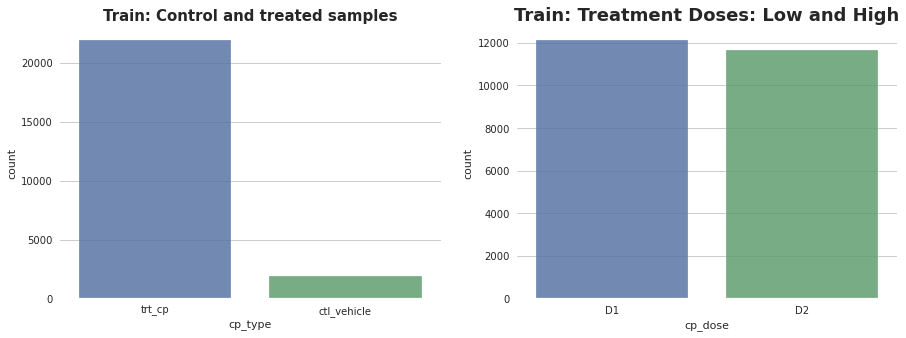

In [9]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(x='cp_type', data=train_features, alpha=0.85)
plt.title('Train: Control and treated samples', fontsize=15, weight='bold')
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x='cp_dose', data=train_features, alpha=0.85)
plt.title('Train: Treatment Doses: Low and High',weight='bold', fontsize=18)
plt.show()

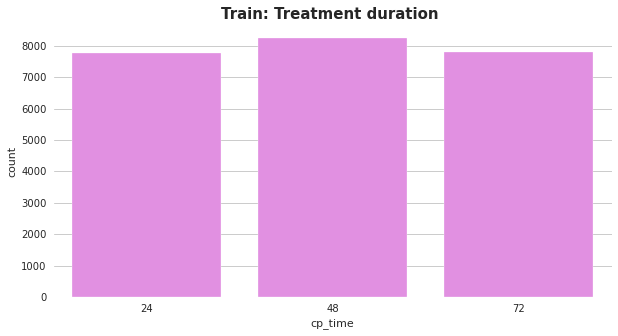

In [10]:
plt.figure(figsize=(10,5))
sns.countplot( train_features['cp_time'], color='violet')
plt.title("Train: Treatment duration ", fontsize=15, weight='bold')
plt.show()

***
> ### Genes Expression and Cells Viability Features

In [11]:
GENES = [g for g in train_features.columns if g.startswith("g-")]
print(f"Number of gene features: {len(GENES)}")
CELLS = [c for c in train_features.columns if c.startswith("c-")]
print(f"Number of cell features: {len(CELLS)}")

Number of gene features: 772
Number of cell features: 100


> ### Distribution of Genes:

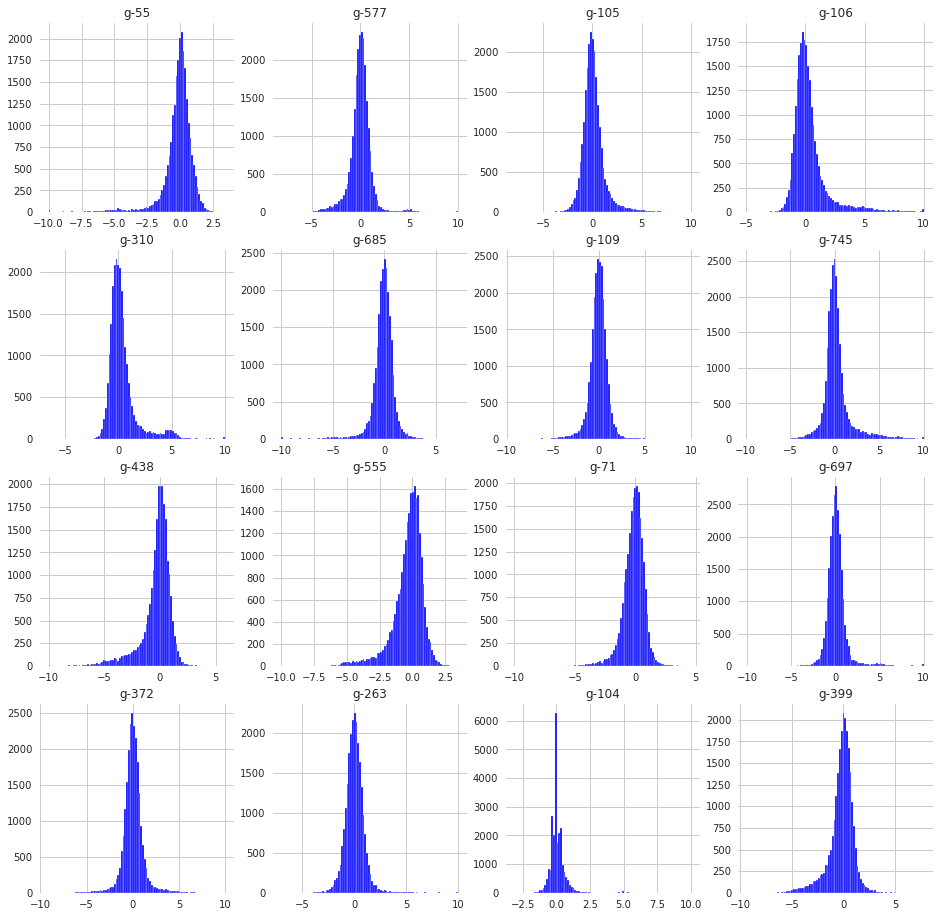

In [12]:
plt.figure(figsize=(16,16))
sns.set_style('whitegrid')
gene_choice=np.random.choice(len(GENES),16)
for i,col in enumerate(gene_choice):
    plt.subplot(4,4,i+1)
    plt.hist(train_features.loc[:,GENES[col]],bins=100,color="blue")
    plt.title(GENES[col])

> ### Distribution of Cells:

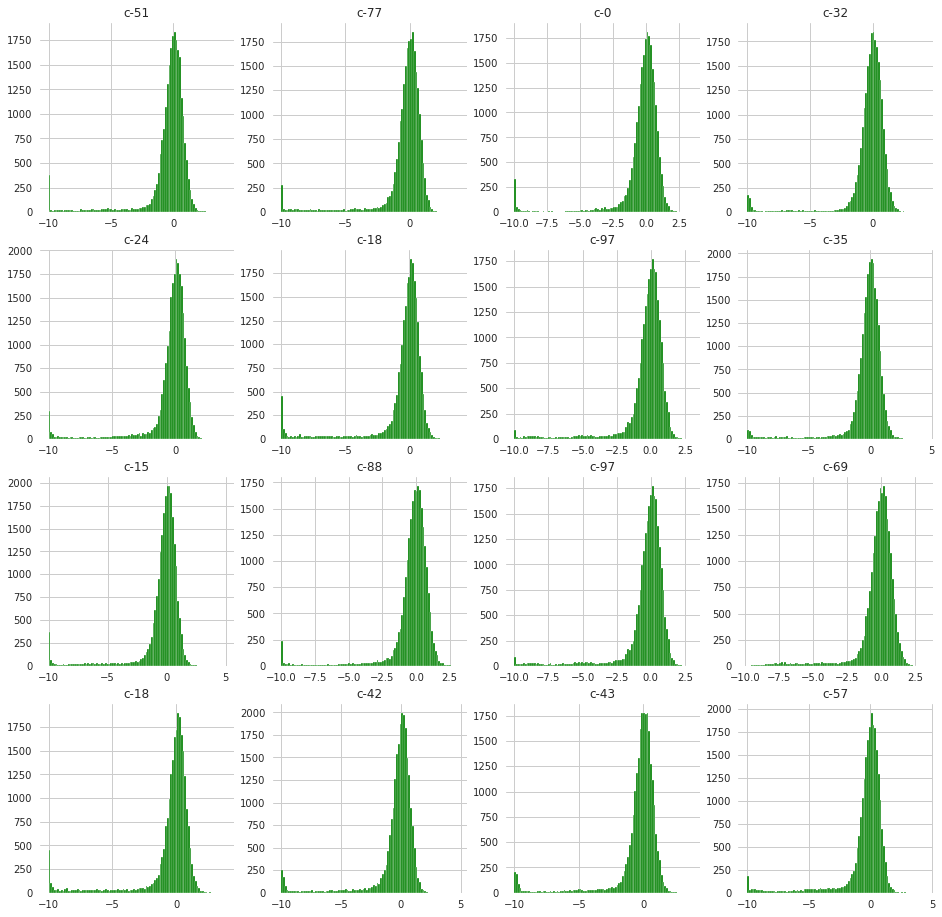

In [13]:
plt.figure(figsize=(16,16))
sns.set_style('whitegrid')
cell_choice=np.random.choice(len(CELLS),16)
for i,col in enumerate(cell_choice):
    plt.subplot(4,4,i+1)
    plt.hist(train_features.loc[:,CELLS[col]],bins=100,color="green")
    plt.title(CELLS[col])

**
***Observation in this EDA:***

Cell and Gene viability should range between the integers 0 and 1. Here, we have values in the range -10 and 6 because the data were z-scored and then normalized using a procedure called [quantile normalization](https://clue.io/connectopedia/glossary#Q).

*A high negative cell viability measure reflects a high fraction of killing [@by the host](https://www.kaggle.com/c/lish-moa/discussion/191487).* In other words:
* High negative values = High number of dead cells
* High positive values = High number of living cells.
***

> ### Cells correlation
**let's see the correlation between gene expression features. (in the treated samples, no control)**

In [14]:
def treated(a):
    treated= a[a['cp_type']=='trt_cp']
    return treated

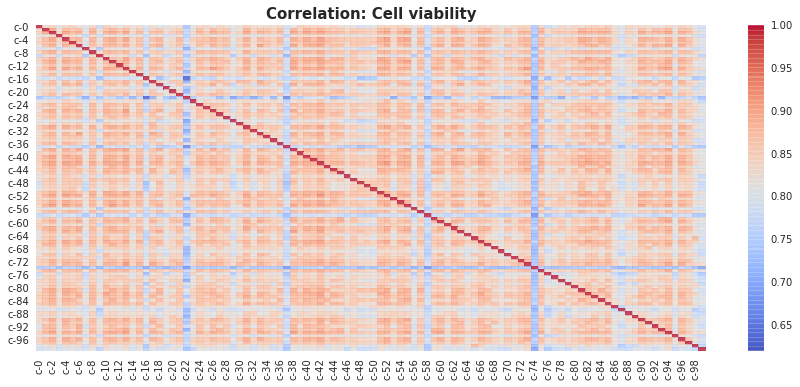

In [15]:
cells = treated(train_features)[CELLS]
plt.figure(figsize=(15,6))
sns.heatmap(cells.corr(),cmap='coolwarm',alpha=0.75)
plt.title('Correlation: Cell viability', fontsize=15, weight='bold')
plt.show()

In [16]:
def corrs(data,col1="Cell 1",col2="Cell 2",rows=5,thresh=0.9,pos=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53]):
    #Correlation between genes
    corre=data.corr()
    #Unstack the dataframe
    s=corre.unstack()
    so=s.sort_values(kind='quicksort',ascending=False)
    #Create new dataframe
    so2=pd.DataFrame(so).reset_index()
    so2=so2.rename(columns={0:'correlation','level_0':col1,'level_1':col2})
    #Filter out the coef 1 correlation between the same drugs
    so2=so2[so2['correlation']!=1]
    #Drop pair duplicates
    so2=so2.reset_index()
    pos=pos
    so3=so2.drop(so2.index[pos])
    so3=so3.drop('index',axis=1)
    #Show the first 10 high correlations
    cm = sns.light_palette("pink", as_cmap=True)
    s = so3.head(rows).style.background_gradient(cmap=cm)
    print(f"{len(so2[so2['correlation']>thresh])/2} {col1} pairs have +{thresh} correlation.")
    return s

In [17]:
corrs(cells,'cell 1','cell 2',rows=8)

173.0 cell 1 pairs have +0.9 correlation.


* **Many high correlations between c- features. This is something to be taken into consideration in feature engineering.**
***

>### Genes correlation:
**let's see the correlation between gene expression features. (in the treated samples, no control)**

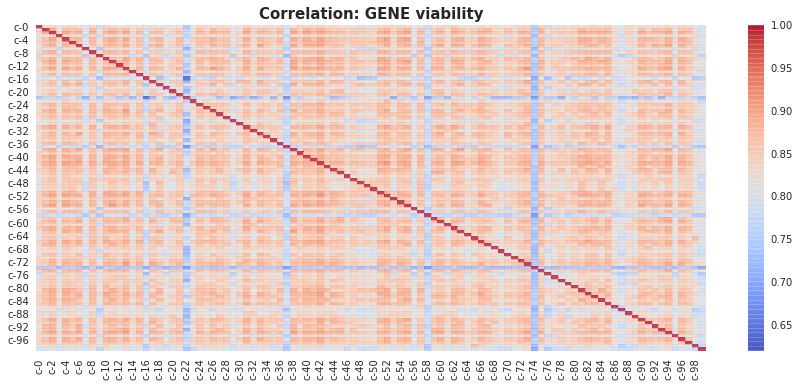

In [18]:
genes = treated(train_features)[GENES]
plt.figure(figsize=(15,6))
sns.heatmap(cells.corr(),cmap='coolwarm',alpha=0.75)
plt.title('Correlation: GENE viability', fontsize=15, weight='bold')
plt.show()

In [19]:
corrs(genes,'Gene 1', 'Gene 2',rows=8)

1.0 Gene 1 pairs have +0.9 correlation.


* **One high correlation between g- features. This is something to be taken into consideration in feature engineering.**
***


# Targets *(MoA)*:

Target features are categorized into two groups; scored and non-scored target features, and features in both of those groups are binary. The competition score is based on the scored target features but non-scored group can still be used for model evaluation, data analysis and feature engineering.

> ## Scored targets:
This is a multi-label classification, we have 207 MoA and we have to find out the mechanism of action of the 5000 drugs that were treated in the `sig_id` samples. A single sample treated with a drug can have many active targets, in other words, one drug can have more than 1 mechanism of action, so we have to predict the mechanisms of action of each drug.

*We will filter the **train_targets_scored** dataset and keep just the treated rows (we discard the control rows because they are not treated with the drugs).*

In [20]:
target_cols_scored=[col for col in train_targets_scored.columns if col not in ['sig_id']]
target_cols_nonscored=[col for col in train_targets_nonscored.columns if col not in ['sig_id']]

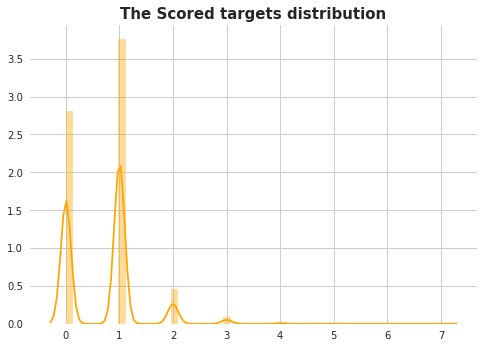

In [21]:
sns.distplot(train_targets_scored[target_cols_scored].sum(axis=1),color='orange')
plt.title("The Scored targets distribution", fontsize=15, weight='bold')
plt.show()

* All the targets are present in at least one sample.
* The presence of the targets is very low in the samples (Mostly less than 0.75%).
* Some targets *(outliers)* have a higher presence in comparison with the rest of targets with a percentage in the range (3%, 4%).

> **Let's have a look over some of these targets**

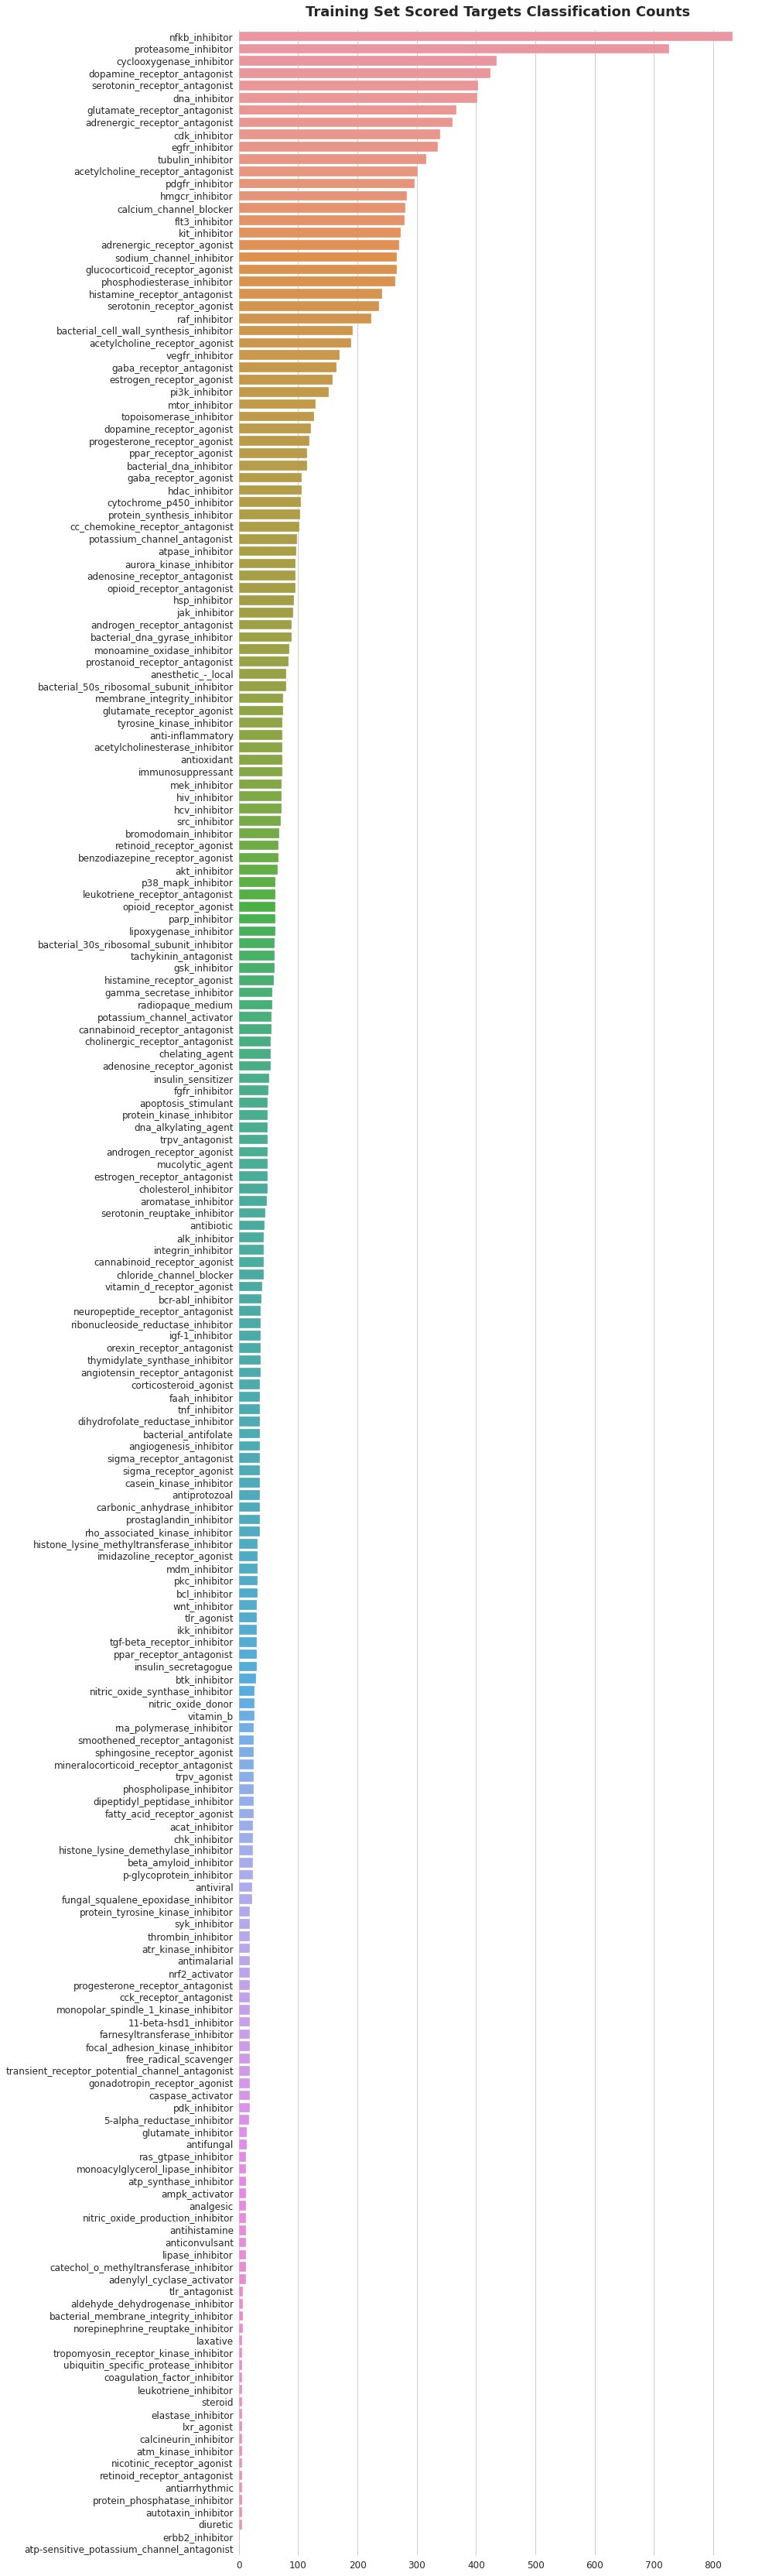

In [22]:
fig = plt.figure(figsize=(12, 60))

sns.barplot(x=train_targets_scored[target_cols_scored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_scored[target_cols_scored].sum(axis=0).sort_values(ascending=False).index)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Training Set Scored Targets Classification Counts', size=18, pad=18, weight='bold')
plt.show()

* It seems we have 2 outliers here: **nfkb_inhibitor** and **proteasome_inhibitor.** 

* We can see many target labels in the plot: inhibitor, agonist, antagonist.
***
### Correlation between scored targets:

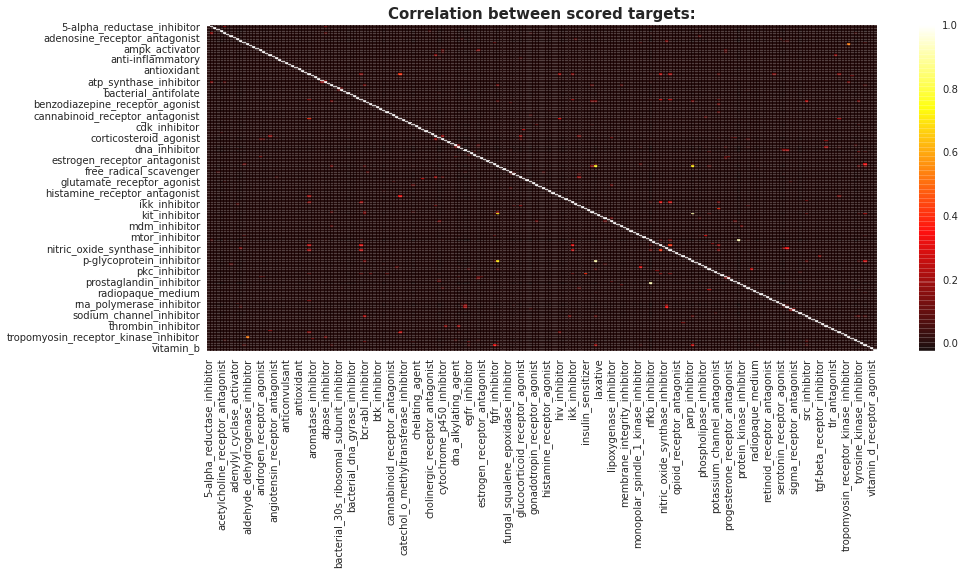

In [23]:
plt.figure(figsize=(15,6))
sns.heatmap(train_targets_scored[target_cols_scored].corr(),cmap='hot',alpha=0.75)
plt.title('Correlation between scored targets:', fontsize=15, weight='bold')
plt.show()

Most of the targets have 0 correlation. It is worth recalling that the presence of active targets in the samples in very low (mainly 1 or 2 targets per sample).

However, we notice some yellow dots *(high correlation)* between some targets. Let's have a closer look over these targets.

### Scored Targets with the highest MoA correlation

In [24]:
corrs(train_targets_scored[target_cols_scored],'Target 1', 'Target 2',rows=5)

2.0 Target 1 pairs have +0.9 correlation.


* It seems we have 2 outliers here: **nfkb_inhibitor** and **proteasome_inhibitor.** 

* We can see many target labels in the plot: inhibitor, agonist, antagonist.
***
* **Observations:**

* 1.It seems we have 2 outliers here: **nfkb_inhibitor** and **proteasome_inhibitor.** 
* We can see many target labels in the plot: inhibitor, agonist, antagonist.
* **nfkb_inhibitor and proteasome_inhibitor** have +0.9 correlation and are highly presented in the samples.
* **Kit_inhibtor** is highly correlated with 2 targets: **pdgfr_inhibitor and flt3_inhibitor**.

***

## Nonscored targets:

In this section, we will have a look over the dataset provided that will not be used in the score. This dataset has 402 MoAs *(more than the 206 MoAs in the targets_scored dataset that will be used in the score).* 

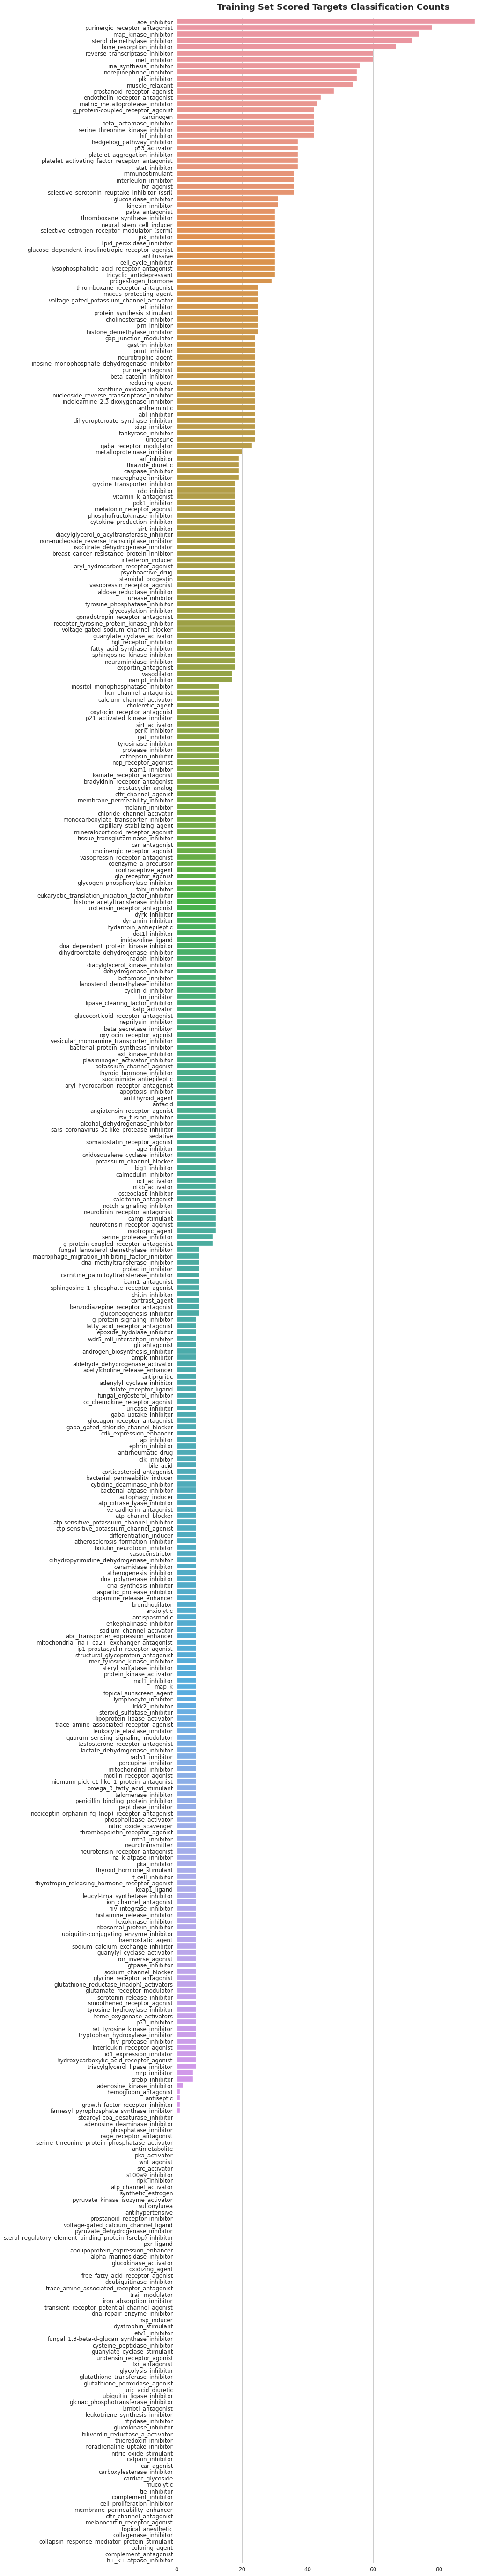

In [25]:
fig = plt.figure(figsize=(12, 100))

sns.barplot(x=train_targets_nonscored[target_cols_nonscored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_nonscored[target_cols_nonscored].sum(axis=0).sort_values(ascending=False).index)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Training Set Scored Targets Classification Counts', size=18, pad=18, weight='bold')
plt.show()

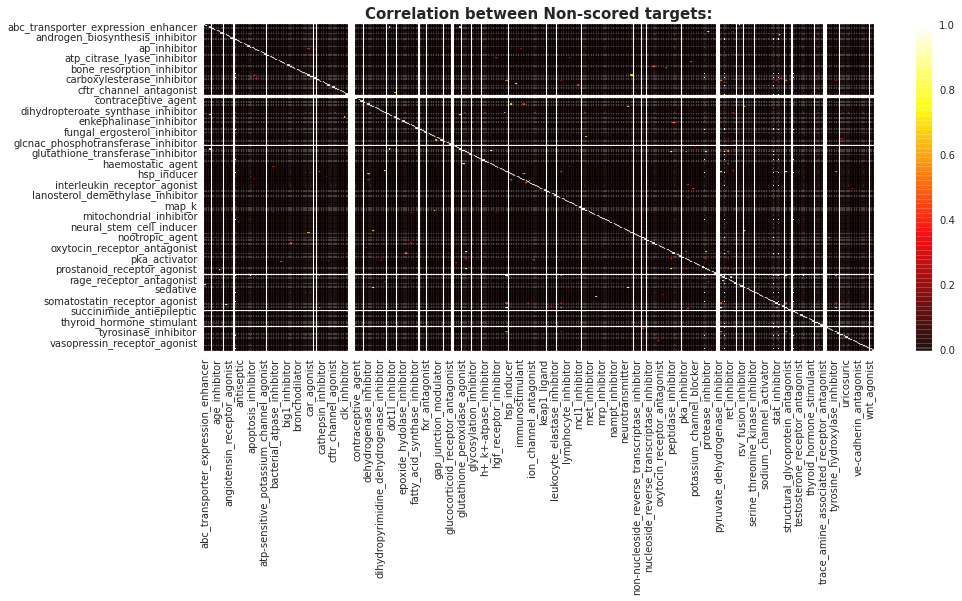

In [26]:
plt.figure(figsize=(15,6))
sns.heatmap(train_targets_nonscored[target_cols_nonscored].corr(),cmap='hot',alpha=0.75)
plt.title('Correlation between Non-scored targets:', fontsize=15, weight='bold')
plt.show()

Horizontal and vertical white lines in non-scored target correlations occur due to NaNs.

### Non-Scored Targets with the highest MoA correlation

In [27]:
corrs(train_targets_nonscored[target_cols_nonscored],'Target 1', 'Target 2',rows=8)

0.0 Target 1 pairs have +0.9 correlation.


**Quite Good Correlation can be found in Non-scored Targets.**
***
Now let's check out correlation in **(scored targets + non-scored targets) i.e. All targets** 
## All Targets:

In [28]:
all_targets=train_targets_scored.merge(train_targets_nonscored, on='sig_id',how='left')
corrs(all_targets[target_cols_nonscored+target_cols_scored],'Target 1', 'Target 2',rows=8)

2.0 Target 1 pairs have +0.9 correlation.


**Great!** This nonscored dataset seems promising. 

### Note:- All Targets can be used for Transfer learning
***
# Test features:
After understanding the relationship between the features and the labels, we move on to the test set to understand the features and their relationship with the train features.
> ## Categorial Features:

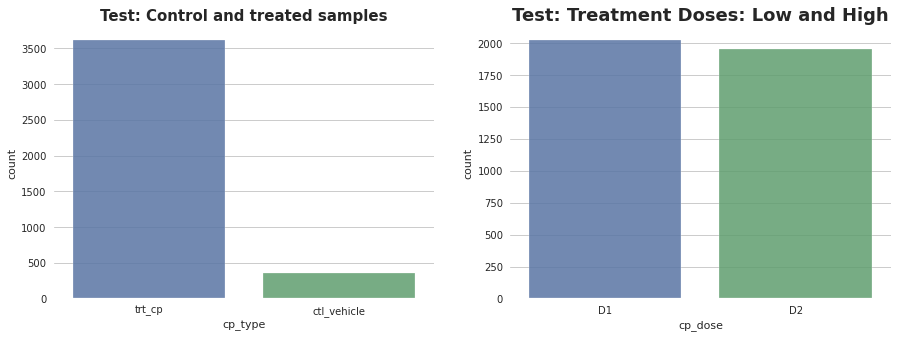

In [29]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.countplot(x='cp_type', data=test_features,alpha=0.85)
plt.title('Test: Control and treated samples', fontsize=15, weight='bold')
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(x='cp_dose', data=test_features,  alpha=0.85)
plt.title('Test: Treatment Doses: Low and High',weight='bold', fontsize=18)
plt.show()

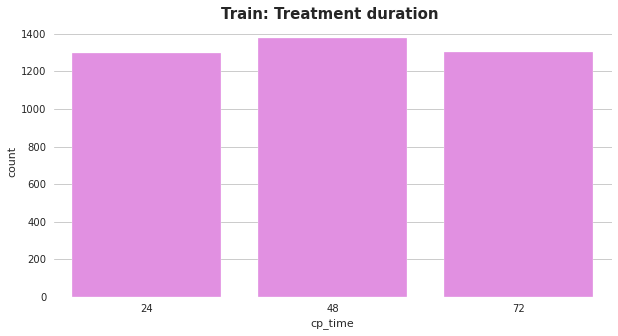

In [30]:
plt.figure(figsize=(10,5))
sns.countplot( test_features['cp_time'], color='violet')
plt.title("Train: Treatment duration ", fontsize=15, weight='bold')
plt.show()

Everything seems similar to the train set:
* The doses are equally applied.
* Very few control samples.
* Same treatment duration 24h, 48h and 72h.

**Good news!** It seems that both train and test datasets are similar in terms of *experimental conditions.* The variation would be in the gene expression and cell viability since the samples used in the test set are different than the train set.

Let's see how different are those samples!

> ## Gene expression:

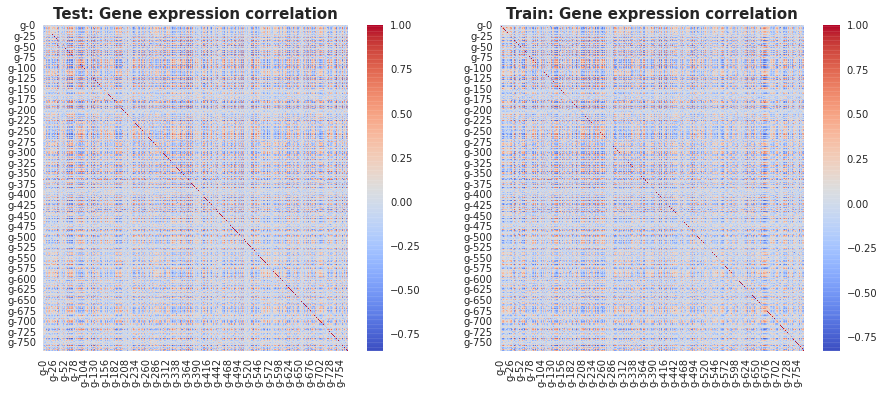

In [31]:
genes2 = treated(test_features)[GENES]
fig=plt.figure(figsize=(15,6))
#first row first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.heatmap(genes2.corr(),cmap='coolwarm',alpha=0.9)
plt.title('Test: Gene expression correlation', fontsize=15, weight='bold')

#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.heatmap(genes.corr(), cmap='coolwarm', alpha=0.9)
plt.title('Train: Gene expression correlation', fontsize=15, weight='bold')
plt.show()

We can see several high positive and negative correlations between some genes, same as in the train set

In [32]:
corrs(genes2,'Gene 1', 'Gene 2',rows=8)

1.0 Gene 1 pairs have +0.9 correlation.


> ## Cell viability:

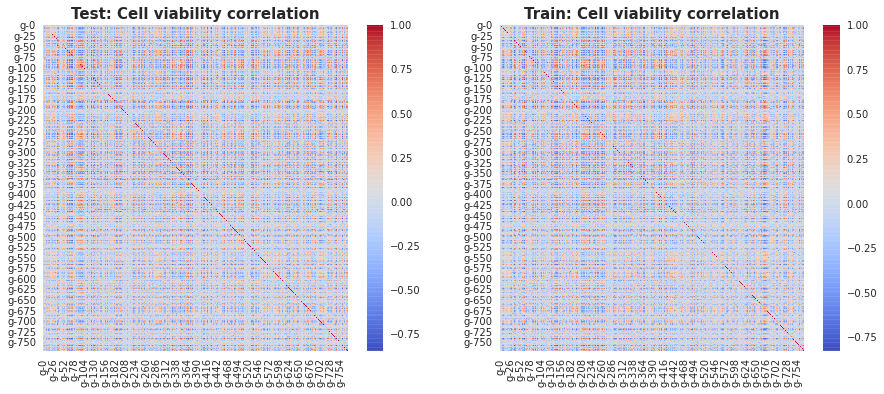

In [33]:
cells2 = treated(test_features)[CELLS]
fig=plt.figure(figsize=(15,6))
#first row first col
ax1 = plt.subplot2grid((1,2),(0,0))
sns.heatmap(genes2.corr(),cmap='coolwarm',alpha=0.9)
plt.title('Test: Cell viability correlation', fontsize=15, weight='bold')

#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
sns.heatmap(genes.corr(), cmap='coolwarm', alpha=0.9)
plt.title('Train: Cell viability correlation', fontsize=15, weight='bold')
plt.show()

In [34]:
corrs(cells2,'Cells 1', 'Cells 2',rows=8)

455.0 Cells 1 pairs have +0.9 correlation.


* **Test set cell features have better correlation than Train set**
* **The order of the cells correlation is different in the test set!**
***

> ## Drug IDs:
`Train_drug.csv` contains anonymous drug ids of every signature id in training set. There are 3289 unique drugs while there are 23814 unique signatures. This means some drugs are used more than 6 times (2 different doses x 3 different durations). This data can be useful for cross-validations and outlier detection.

#### Most frequent drugs in the drug set:

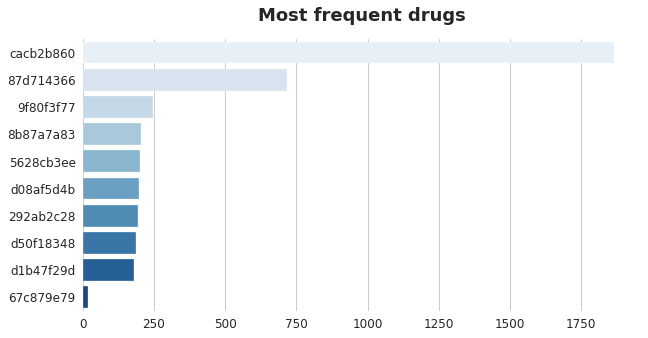

In [35]:
fig = plt.figure(figsize=(10,5))

sns.barplot(x=train_drug['drug_id'].value_counts().values[:10],
            y=train_drug['drug_id'].value_counts().index[:10],palette = "Blues")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlabel('')
plt.ylabel('')
plt.title('Most frequent drugs', size=18, pad=18, weight='bold')
plt.show()

In [36]:
print('First observation:')
print(f"Number of rows of the Control vehicle is {len(train_features[train_features['cp_type']=='ctl_vehicle'])}")
print(f"Number of rows of the Drug cacb2b860 is {train_drug.drug_id.value_counts()[0]}")

First observation:
Number of rows of the Control vehicle is 1866
Number of rows of the Drug cacb2b860 is 1866


So, Drug cacb2b860 is the control vehicle, this explains it's high presence in the train set. The second most frequent drugs is 87d714366 with 718 rows!

In [37]:
drug_count = train_drug[['drug_id']].value_counts().to_frame()
drug_count = drug_count.rename(columns={0:'drug_count'})
drug_count2=drug_count['drug_count'].value_counts().to_frame().reset_index()
drug_count2=drug_count2.rename(columns={'index': 'Samples per drug', 'drug_count':'Number of Drugs'})
drug_count2[:12]

Samples per drug  Number of Drugs
0                  6             2774
1                  7              196
2                  1              129
3                  5               66
4                 12               64
5                 13               25
6                 14                6
7                 11                4
8                  8                4
9                  2                3
10                 4                3
11                18                3

**Observations:**
* 2774 drugs out of 3700 drugs have 6 rows that correspond to 2 doses and 3 treatment times. 
* Only 64 drugs have 12 samples, I was expecting more drugs to be profiled twice.
* Only 3 drugs have 18 sample, the drugs were profiled 3 times.
***
### Conclusion of EDA:
* Train and Test Set share Quite same Distribution.
* Cell Features are highly correlation among themselves (can be used to create new features).
* Data is quite skewed , so some statistical features can be also be created.
* Drug_id can play an important role for cross-validaton strategy as explained by this [topic](https://www.kaggle.com/c/lish-moa/discussion/195195).
The Cross Validation strategy i have used for submission is Multi-label stratified Kfold. 
* All Targets are highly correlative can be used for transfer learning.
* About 71 Non-scoredtargets don't have mechanism of action so can be dropped while pre-training.
***
# Feature Engineering:
> ## Adversarial Validation and Feature Importance:

To study about Adversarial Validation please refer --> [PAGE](https://towardsdatascience.com/adversarial-validation-ca69303543cd) | 
[YouTube Video](https://www.youtube.com/watch?v=7cUCDRaIZ7I&feature=youtu.be)

Categorical features; `cp_type`, `cp_time` and `cp_dose` are omitted in adversarial validation. Only gene expression and cell viability features are used. Basically we going to replace our targets for both datasets (0 for train and 1 for test), then we going build a classifier which tries to predict which observation belongs to train and which one belongs to test set. If datasets randomly selected from similar roots it should be really hard for the classifier to separate them. But if there is systematic selection differences between train and test sets then classifier should be able to capture this trend. So we want our models score lower for the next section (0.50 AUC) because higher detection rate means higher difference between train and test datasets, so let's get started...

In [38]:
train_features['target'] = 0
test_features['target'] = 1

X = pd.concat([train_features.loc[:,GENES+CELLS], test_features.loc[:,GENES+CELLS]]).reset_index(drop=True)
y = pd.concat([train_features.loc[:, 'target'], test_features.loc[:, 'target']]).reset_index(drop=True)

Running LightGBM Adversarial Validation Model
---------------------------------------------

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.943188	valid_1's auc: 0.496434
Early stopping, best iteration is:
[1]	training's auc: 0.559511	valid_1's auc: 0.506945

Fold 1 - ROC AUC Score 0.506945

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.95036	valid_1's auc: 0.510922
Early stopping, best iteration is:
[2]	training's auc: 0.622172	valid_1's auc: 0.529805

Fold 2 - ROC AUC Score 0.529805

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.949718	valid_1's auc: 0.505115
Early stopping, best iteration is:
[33]	training's auc: 0.904033	valid_1's auc: 0.517553

Fold 3 - ROC AUC Score 0.517553

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.947938	valid_1's auc: 0.528134
Early stopping, best iteration is:
[37]	training's auc: 0.916801	valid_1's auc: 0

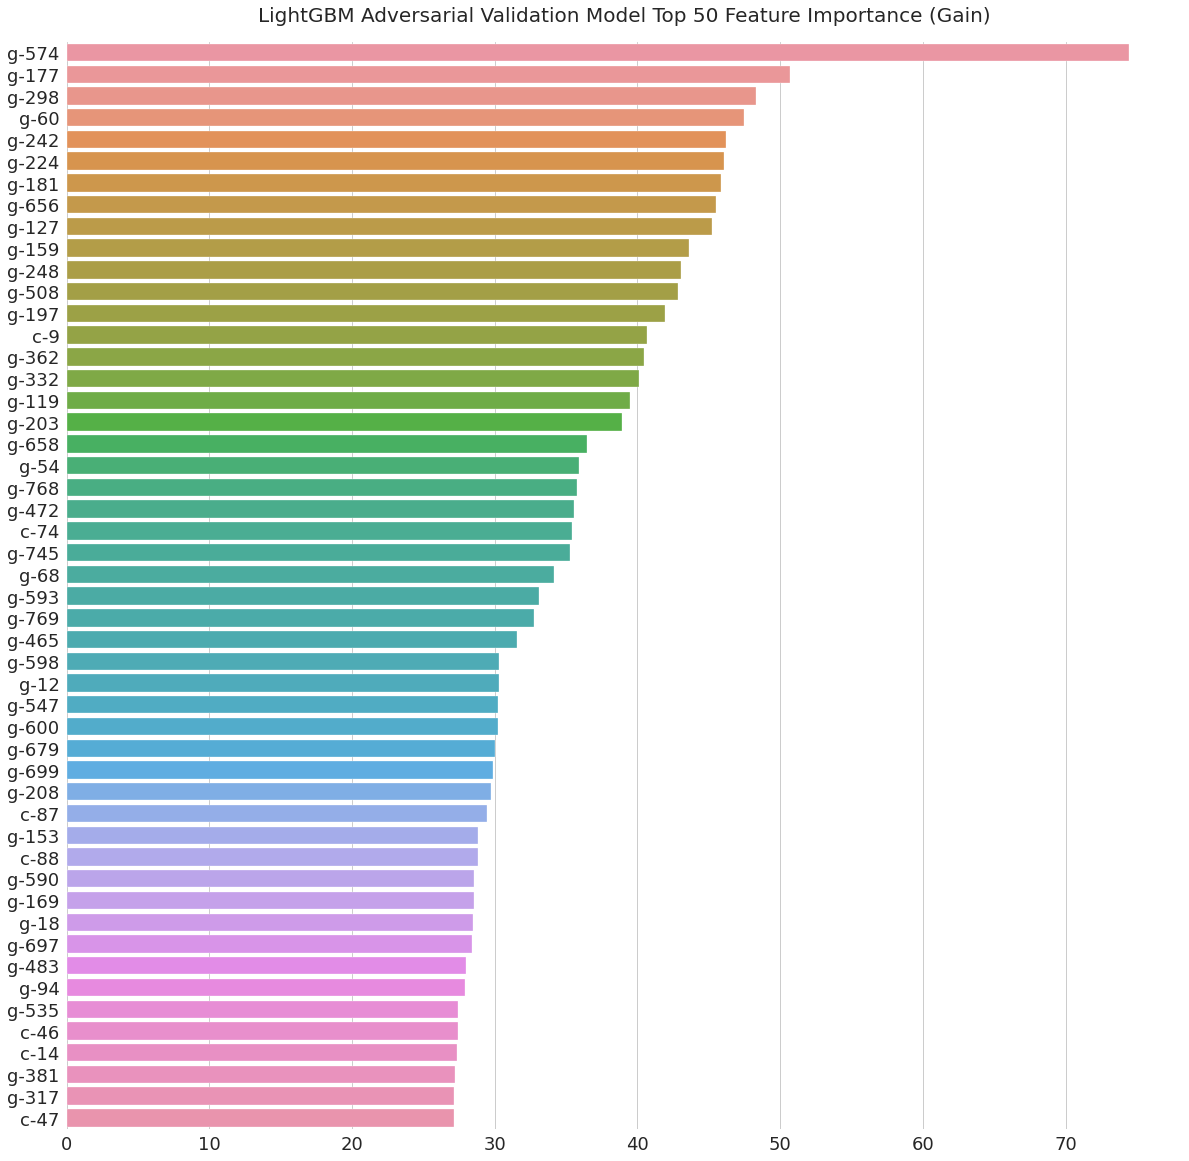

In [39]:
k=5
skf=StratifiedKFold(n_splits=k,random_state=721991,shuffle=True)
scores=[]
oof_predictions = pd.DataFrame(np.zeros((X.shape[0], 1)), columns=['target'])
feature_importance = pd.DataFrame(np.zeros((X.shape[1], k)), columns=[f'Fold_{i}_Importance' for i in range(1, k + 1)], index=X.columns)
parameters = {
    'num_iterations': 500,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 5, 
    'learning_rate': 0.05,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.9,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'max_depth': -1,
    'objective': 'binary',
    'seed': 721991,
    'feature_fraction_seed': 721991,
    'bagging_seed': 721991,
    'drop_seed': 721991,
    'data_random_seed': 721991,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'auc',
    'n_jobs': -1,   
}
print('Running LightGBM Adversarial Validation Model\n' + ('-' * 45) + '\n')
for fold,(train_idx,val_idx) in enumerate(skf.split(X, y), 1):
    trn_data=lgb.Dataset(X.iloc[train_idx,:],label=y.iloc[train_idx])
    val_data=lgb.Dataset(X.iloc[val_idx,:],label=y.iloc[val_idx])
    model=lgb.train(parameters,trn_data,valid_sets=[trn_data, val_data], verbose_eval=50)
    feature_importance.iloc[:,fold-1]=model.feature_importance(importance_type='gain')
    predictions = model.predict(X.iloc[val_idx, :], num_iteration=model.best_iteration)
    oof_predictions.loc[val_idx, 'target'] = predictions
    score=roc_auc_score(y.iloc[val_idx],predictions)
    scores.append(score)
    print(f'\nFold {fold} - ROC AUC Score {score:.6}\n')
oof_score = roc_auc_score(y, oof_predictions)
print(f'\n{"-" * 30}\nLightGBM Adversarial Validation Model Mean ROC AUC Score {np.mean(scores):.6} [STD:{np.std(scores):.6}]')
print(f'LightGBM Adversarial Validation Model OOF ROC AUC Score: {oof_score:.6}\n{"-" * 30}')

plt.figure(figsize=(20, 20))
feature_importance['Mean_Importance'] = feature_importance.sum(axis=1) / k
feature_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=feature_importance.index[:50], data=feature_importance[:50])
plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('LightGBM Adversarial Validation Model Top 50 Feature Importance (Gain)', size=20, pad=20)

plt.show()

del X, y, oof_predictions, feature_importance, parameters, scores, oof_score

Adversarial validation model yields approx. **0.525** ROC AUC score which suggests that training and public test set are similar. Features at the top of importance plot have higher gain, because they have different means in training and public test set due to distribution tail extremities. This could be related to small sample size of public test set, and it's not necessarily have to be expected in private test set.
***

In [40]:
#seeding Everything
seed = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(seed)

***
> ## Feature Scaling

It can seen from the prior visualizations that continuous features are between different ranges. Feature scaling can both improve model performance and speed up convergence at the same time.In this competition,`Quantile Transformer` Played an important role for scaling of GENE and CELL features reason being this method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.Zero centric data perform better in algorithms like PCA, on the other hand min max scaled data may perform better in neural networks.

Min max scaler and standard scaler are heavily affected by outliers, however gaussian rank scaler yields more robust results. Gaussian rank scaled data have symmetrical tails unlike others.

Here's a quick exciting video about Quantile Normalization-[YouTube Video](https://www.youtube.com/watch?v=ecjN6Xpv6SE)

**Train set before Transformation**

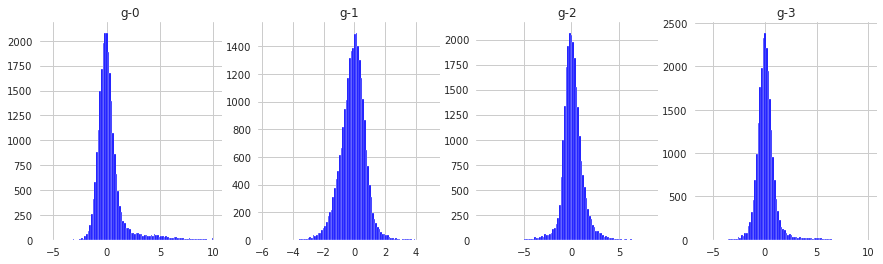

In [41]:
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
gene_choice=[0,1,2,3]
for i,col in enumerate(gene_choice):
    plt.subplot(1,4,i+1)
    plt.hist(train_features.loc[:,GENES[col]],bins=100,color="blue")
    plt.title(GENES[col])

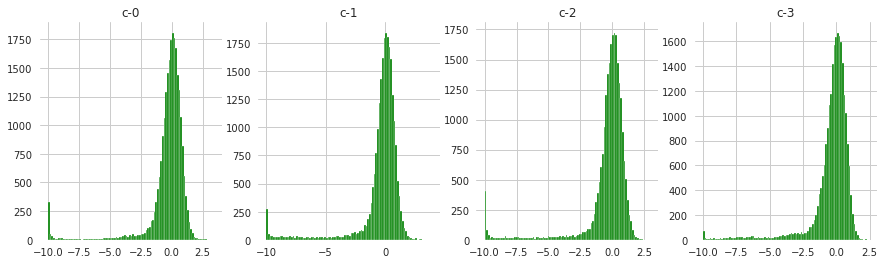

In [42]:
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
cell_choice=[0,1,2,3]
for i,col in enumerate(cell_choice):
    plt.subplot(1,4,i+1)
    plt.hist(train_features.loc[:,CELLS[col]],bins=100,color="green")
    plt.title(CELLS[col])

In [43]:
qt = QuantileTransformer(n_quantiles=100,random_state=42,output_distribution='normal')
train_features[GENES+CELLS] = qt.fit_transform(train_features[GENES+CELLS])
test_features[GENES+CELLS] = qt.transform(test_features[GENES+CELLS])

**After applying Quantile Transformation , obtained Uniformaity in Train set is easily noticiable.**

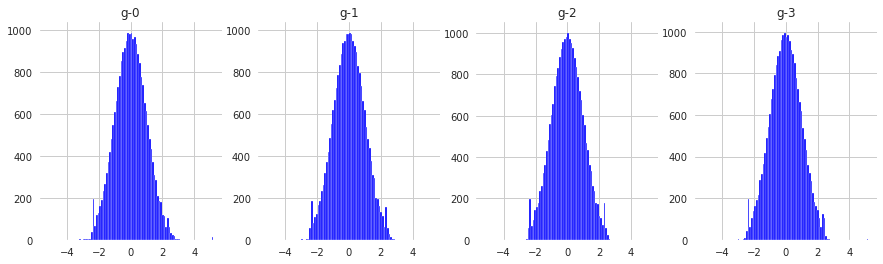

In [44]:
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
gene_choice=[0,1,2,3]
for i,col in enumerate(gene_choice):
    plt.subplot(1,4,i+1)
    plt.hist(train_features.loc[:,GENES[col]],bins=100,color="blue")
    plt.title(GENES[col])

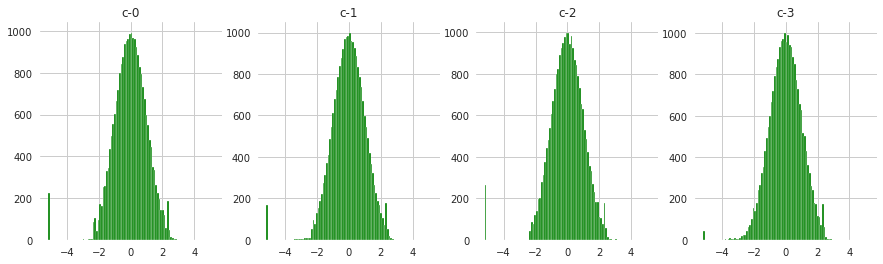

In [45]:
plt.figure(figsize=(15,4))
sns.set_style('whitegrid')
cell_choice=[0,1,2,3]
for i,col in enumerate(cell_choice):
    plt.subplot(1,4,i+1)
    plt.hist(train_features.loc[:,CELLS[col]],bins=100,color="green")
    plt.title(CELLS[col])

***
> ### Dimensionality Reduction (PCA)
PCA is a linear transformation that projects the data into another space, where vectors of projections are defined by variance of the data. PCA results can be evaluated with reconstruction error and cumulative percent variance.

For Finding the optimal number of components for PCA of genes and cells please refer this [notebook](https://www.kaggle.com/kushal1506/deciding-n-components-in-pca)

In [46]:
#GENES
n_comp = 600  #<--Update

#pca_g = PCA(n_components=n_comp, random_state=42)
#data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
#gpca= (pca_g.fit(data[GENES]))

gpca= load(open('../input/moa-tabnet-last/gpca.pkl', 'rb')) #<--Loading saved features using pickle load feature
train2= (gpca.transform(train_features[GENES]))
test2 = (gpca.transform(test_features[GENES]))

train_gpca = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test_gpca = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train_gpca), axis=1)
test_features = pd.concat((test_features, test_gpca), axis=1)

#dump(gpca, open('gpca.pkl', 'wb')) #<--Saving created features for just inference kernels

In [47]:
#CELLS
n_comp = 50  #<--Update

#pca_c = PCA(n_components=n_comp, random_state=42)
#data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
#cpca= (pca_c.fit(data[CELLS]))

cpca= load(open('../input/moa-tabnet-last/cpca.pkl', 'rb'))
train2= (cpca.transform(train_features[CELLS]))
test2 = (cpca.transform(test_features[CELLS]))

train_cpca = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test_cpca = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train_cpca), axis=1)
test_features = pd.concat((test_features, test_cpca), axis=1)

#dump(cpca, open('cpca.pkl', 'wb'))

>### Variance Threshold
Another approach for feature selection is eliminating features that have lower variance than a predefined threshold. Variance is the average of the squared differences from the mean, so it measures how far the data points are spread out from the mean. If the variance is low or close to zero, then a feature is approximately constant and will not improve the performances of the models. In that case, it should be removed.

In [48]:
print(f'Number of features before Variance thresholding - {train_features.shape[1]}')

Number of features before Variance thresholding - 1527


In [49]:
c_n = [f for f in list(train_features.columns) if f not in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']]
mask = (train_features[c_n].var() >= 0.85).values #<-- In this I have kept threshold value equal to 0.85
tmp = train_features[c_n].loc[:, mask]
train_features = pd.concat([train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], tmp], axis=1)
tmp = test_features[c_n].loc[:, mask]
test_features = pd.concat([test_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose']], tmp], axis=1)

In [50]:
print(f'Number of features after Variance thresholding - {train_features.shape[1]}')

Number of features after Variance thresholding - 1028


So U can notice that many features are removed that have variance less than 0.85.
***
>### K-Means Clustering
The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.You’ll define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.
Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.
In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

This is a multi-Label problem so applying K-means maybe beneficial.

Here's a short video to refer K-means Clustering. [YouTube Video](https://www.youtube.com/watch?v=4b5d3muPQmA&t=0s&index=2&list=PLlcyUWQOcKAgDvemP5qJp0kcvWU5n-d7V)

In [51]:
from sklearn.cluster import KMeans
def fe_cluster_genes(train, test, n_clusters_g = 22, SEED = 42):
    
    features_g = GENES
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
  #      data = pd.concat([train_, test_], axis = 0)
  #      kmeans_genes = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
  #      dump(kmeans_genes, open('kmeans_genes.pkl', 'wb'))
        kmeans_genes = load(open('../input/moa-tabnet-last/kmeans_genes.pkl', 'rb'))
        train[f'clusters_{kind}'] = kmeans_genes.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans_genes.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    return train, test

train_features2 ,test_features2=fe_cluster_genes(train_features2,test_features2)

In [52]:
def fe_cluster_cells(train, test, n_clusters_c = 4, SEED = 42):
    
    features_c = CELLS
    
    def create_cluster(train, test, features, kind = 'c', n_clusters = n_clusters_c):
        train_ = train[features].copy()
        test_ = test[features].copy()
 #       data = pd.concat([train_, test_], axis = 0)
 #       kmeans_cells = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
 #       dump(kmeans_cells, open('kmeans_cells.pkl', 'wb'))
        kmeans_cells = load(open('../input/moa-tabnet-last/kmeans_cells.pkl', 'rb'))
        train[f'clusters_{kind}'] = kmeans_cells.predict(train_.values)
        test[f'clusters_{kind}'] = kmeans_cells.predict(test_.values)
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

train_features2 ,test_features2=fe_cluster_cells(train_features2,test_features2)

In [53]:
train_pca=pd.concat((train_gpca,train_cpca),axis=1)
test_pca=pd.concat((test_gpca,test_cpca),axis=1)

In [54]:
# Applying K-means clustering on pca generated features
def fe_cluster_pca(train, test,n_clusters=5,SEED = 42):
  #      data=pd.concat([train,test],axis=0)
  #      kmeans_pca = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
  #      dump(kmeans_pca, open('kmeans_pca.pkl', 'wb'))
        kmeans_pca = load(open('../input/moa-tabnet-last/kmeans_pca.pkl', 'rb'))
        train[f'clusters_pca'] = kmeans_pca.predict(train.values)
        test[f'clusters_pca'] = kmeans_pca.predict(test.values)
        train = pd.get_dummies(train, columns = [f'clusters_pca'])
        test = pd.get_dummies(test, columns = [f'clusters_pca'])
        return train, test
train_cluster_pca ,test_cluster_pca = fe_cluster_pca(train_pca,test_pca)

In [55]:
train_cluster_pca = train_cluster_pca.iloc[:,650:]
test_cluster_pca = test_cluster_pca.iloc[:,650:]

In [56]:
train_features_cluster=train_features2.iloc[:,876:]
test_features_cluster=test_features2.iloc[:,876:]

>### Using statistical Features

In [57]:
# some important g-features
gsquarecols=['g-574','g-211','g-216','g-0','g-255','g-577','g-153','g-389','g-60','g-370','g-248','g-167','g-203','g-177','g-301','g-332','g-517','g-6','g-744','g-224','g-162','g-3','g-736','g-486','g-283','g-22','g-359','g-361','g-440','g-335','g-106','g-307','g-745','g-146','g-416','g-298','g-666','g-91','g-17','g-549','g-145','g-157','g-768','g-568','g-396']

In [58]:
def fe_stats(train, test):
    
    # statistical Features
    
    features_g = GENES
    features_c = CELLS
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
        # Using pair of highly correlative features
        
        df['c52_c42'] = df['c-52'] * df['c-42']
        df['c13_c73'] = df['c-13'] * df['c-73']
        df['c26_c13'] = df['c-26'] * df['c-13']
        df['c33_c6'] = df['c-33'] * df['c-6']
        df['c11_c55'] = df['c-11'] * df['c-55']
        df['c38_c63'] = df['c-38'] * df['c-63']
        df['c38_c94'] = df['c-38'] * df['c-94']
        df['c13_c94'] = df['c-13'] * df['c-94']
        df['c4_c52'] = df['c-4'] * df['c-52']
        df['c4_c42'] = df['c-4'] * df['c-42']
        df['c13_c38'] = df['c-13'] * df['c-38']
        df['c55_c2'] = df['c-55'] * df['c-2']
        df['c55_c4'] = df['c-55'] * df['c-4']
        df['c4_c13'] = df['c-4'] * df['c-13']
        df['c82_c42'] = df['c-82'] * df['c-42']
        df['c66_c42'] = df['c-66'] * df['c-42']
        df['c6_c38'] = df['c-6'] * df['c-38']
        df['c2_c13'] = df['c-2'] * df['c-13']
        df['c62_c42'] = df['c-62'] * df['c-42']
        df['c90_c55'] = df['c-90'] * df['c-55']
        df['c26_c38'] = df['c-26'] * df['c-38']
        df['c90_c13'] = df['c-90'] * df['c-13']
        df['c85_c31'] = df['c-85'] * df['c-31']
        df['c63_c42'] = df['c-63'] * df['c-42']
        df['c94_c11'] = df['c-94'] * df['c-11']
        df['c94_c60'] = df['c-94'] * df['c-60']
        df['c55_c42'] = df['c-55'] * df['c-42']
        df['g37_c50'] = df['g-37'] * df['g-50']
        
        # Making Polynomial Features
        
        for feature in features_c:
             df[f'{feature}_squared'] = df[feature] ** 2     
                
        for feature in gsquarecols:
            df[f'{feature}_squared'] = df[feature] ** 2        
        
    return train, test

train_features2,test_features2=fe_stats(train_features2,test_features2)

In [59]:
train_features_stats=train_features2.iloc[:,902:]
test_features_stats=test_features2.iloc[:,902:]

In [60]:
train_features = pd.concat((train_features, train_features_cluster,train_cluster_pca,train_features_stats), axis=1)
test_features = pd.concat((test_features, test_features_cluster,test_cluster_pca,test_features_stats), axis=1)

>### Extracting and removing 71 Non-scored targets without any MoA.

In [61]:
#Extract unique elements per column
cols2 = train_targets_nonscored.columns.to_list() # specify the columns whose unique values you want here
uniques2 = {col: train_targets_nonscored[col].nunique() for col in cols2}
uniques2=pd.DataFrame(uniques2, index=[0]).T
uniques2=uniques2.rename(columns={0:'count'})
uniques2= uniques2.drop('sig_id', axis=0)
print(f"{len(uniques2[uniques2['count']==1])} targets without ANY mechanism of action in the nonscored dataset")

71 targets without ANY mechanism of action in the nonscored dataset


In [62]:
nonmoacols=uniques2[uniques2['count']==1].index
train_targets_nonscored_columns = [col for col in list(train_targets_nonscored.columns) if col not in nonmoacols]
train_targets_nonscored=train_targets_nonscored[train_targets_nonscored_columns]

In [63]:
train = train_features.merge(train_targets_nonscored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_nonscored.columns]
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target=target[target_cols]

train = pd.get_dummies(train, columns=['cp_time','cp_dose'])
test_ = pd.get_dummies(test, columns=['cp_time','cp_dose'])

feature_cols = [c for c in train.columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['sig_id']]

In [64]:
train_features_tabnet=train[feature_cols]
X_test_tabnet=test_[feature_cols].values

In [65]:
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [66]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

***
# Ensemble
>### Pytorch Pre-train (Using Predictions on Non-scored Targets as Meta-Features)

In [67]:
class NNModel(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(NNModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.2)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x), 1e-3)
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

>#### Label Smoothing:
`Label smoothing`, in a nutshell, is a way to make our model more robust so that it generalizes well. 
In this Competition,Label Smoothing played an important role in climbing the LB and improving our models.This is an Inference kernel so label smoothing is not used in this kernel.

To have a better Understanding about Label smoothing, please refer this [Page](https://medium.com/@nainaakash012/when-does-label-smoothing-help-89654ec75326).
* Note:- Label Smoothing is applied on training loss function not on validation loss function.

In [68]:
#class SmoothBCEwLogits(_WeightedLoss):
#    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
#        super().__init__(weight=weight, reduction=reduction)
#        self.smoothing = smoothing
#        self.weight = weight
#        self.reduction = reduction

#    @staticmethod
#    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
#        assert 0 <= smoothing < 1
#        with torch.no_grad():
#            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
#        return targets

#    def forward(self, inputs, targets):
#        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
#            self.smoothing)
#        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

#        if  self.reduction == 'sum':
#            loss = loss.sum()
#        elif  self.reduction == 'mean':
#            loss = loss.mean()

#        return loss

In [69]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
NFOLDS = 7
num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=2048
BATCH_SIZE=256

#### Predicting Non-scored Targets

In [70]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = NNModel(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    model.load_state_dict(torch.load(f"../input/moa-pretrained-non-scored-targets-as-meta-features/SEED{seed}_FOLD{fold}_nonscored.pth",map_location=torch.device(DEVICE)))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return predictions

In [71]:
def run_k_fold(NFOLDS, seed):
    predictions = np.zeros((len(test), len(target_cols)))
    for fold in range(NFOLDS):
        pred_ = run_training(fold, seed)
        predictions += pred_ / NFOLDS
    return predictions

In [72]:
SEED = [0,1,2,3,4,5,6] 
predictions = np.zeros((len(test), len(target_cols)))
for seed in SEED:
    predictions_ = run_k_fold(NFOLDS, seed)
    predictions += predictions_ / len(SEED)
test_[target_cols] = predictions

In [73]:
train = train.merge(train_targets_scored, on='sig_id')
target = train[train_targets_scored.columns]
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

In [74]:
feature_cols_NN = [c for c in train.columns if c not in target_cols]
feature_cols_NN = [c for c in feature_cols_NN if c not in ['sig_id','kfold']]

In [75]:
num_features=len(feature_cols_NN)
num_targets=len(target_cols)
hidden_size=2048

#### Predicting Scored Targets for pretrain model

In [76]:
def run_training(fold, seed):
    
    seed_everything(seed)
    x_test = test_[feature_cols_NN].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = NNModel(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"../input/moa-pretrained-non-scored-targets-as-meta-features/SEED{seed}_FOLD{fold}_scored.pth",map_location=torch.device(DEVICE)))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return predictions

In [77]:
def run_k_fold(NFOLDS, seed):
    predictions = np.zeros((len(test), len(target_cols)))
    for fold in range(NFOLDS):
        pred_ = run_training(fold, seed)
        predictions += pred_ / NFOLDS
    return predictions

In [78]:
# Averaging on multiple SEEDS

SEED = [0,1,2,3,4,5,6]  #<-- Update
predictions = np.zeros((len(test), len(target_cols)))
for seed in SEED:
    predictions_ = run_k_fold(NFOLDS, seed)
    predictions += predictions_ / len(SEED)
preds_pretrain = predictions 

In [79]:
preds_pretrain

array([[0.00140577, 0.00202208, 0.00279325, ..., 0.00226992, 0.0046944 ,
        0.0020383 ],
       [0.00077993, 0.00158403, 0.0026615 , ..., 0.00149983, 0.0014467 ,
        0.00331982],
       [0.00118728, 0.00131158, 0.00220143, ..., 0.00186463, 0.00120276,
        0.0030669 ],
       ...,
       [0.00144742, 0.0013259 , 0.0012909 , ..., 0.00171783, 0.00071309,
        0.00126789],
       [0.00207628, 0.00157587, 0.001579  , ..., 0.00231407, 0.00077906,
        0.00344806],
       [0.0009806 , 0.00138762, 0.00180346, ..., 0.00250592, 0.00084531,
        0.00192939]])

>### Pytorch Transfer learning (Using All Targets)

In [80]:
class ResNetModel(nn.Module):
    def __init__(self, num_features, num_targets):
        super(ResNetModel, self).__init__()
        self.hidden_size = [2048, 1500, 1250, 1000]
        self.dropout_value = [0.3, 0.3, 0.3, 0.3]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))
        
        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x

In [81]:
num_features = len(feature_cols)
num_features

1248

In [82]:
def run_training(fold_id, seed_id):
    
    seed_everything(seed_id)
    
    model = ResNetModel(num_features, num_targets)
    model.load_state_dict(torch.load(f"../input/pytorch-transfer-learning-last/SCORED_ONLY_SEED{seed_id}_FOLD{fold_id}_.pth",map_location=torch.device(DEVICE)))
    model.to(DEVICE)                    

    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=128, shuffle=False)
    
    predictions = np.zeros((len(test_), num_targets))
    predictions = inference_fn(model, testloader, DEVICE)
    return predictions

In [83]:
def run_k_fold(NFOLDS, seed_id):
    predictions = np.zeros((len(test), len(target_cols)))
    for fold_id in range(NFOLDS):
        pred_ = run_training(fold_id, seed_id)
        predictions += pred_ / NFOLDS   
    return predictions

In [84]:
SEED = [0,1,2,3,4,5,6]
predictions = np.zeros((len(test), len(target_cols)))
for seed_id in SEED:
    predictions_ = run_k_fold(NFOLDS, seed_id)
    predictions += predictions_ / len(SEED)
preds_transfer=predictions

In [85]:
preds_transfer

array([[0.00060486, 0.00081544, 0.00268132, ..., 0.00236879, 0.00282413,
        0.00172309],
       [0.00046234, 0.00107241, 0.00139136, ..., 0.00148221, 0.00095226,
        0.00661848],
       [0.00060722, 0.00091572, 0.00180283, ..., 0.00199333, 0.00077837,
        0.00167795],
       ...,
       [0.00319724, 0.00162561, 0.0014387 , ..., 0.0015375 , 0.00049448,
        0.00096388],
       [0.00275454, 0.00085017, 0.00119745, ..., 0.00279212, 0.00071862,
        0.00260279],
       [0.00072805, 0.00136411, 0.00216598, ..., 0.00198564, 0.00067106,
        0.00114975]])

>### Tabnet-1 and Tabnet-2
* About Tabnet: [Discussion-What can TabNet see!](https://www.kaggle.com/c/lish-moa/discussion/194203)

In [86]:
test_cv_preds_1 = []

NB_SPLITS = 7
SEED = [0,1,2,3,4,5,6]
for s in SEED:
    for fold_nb, (train_idx, val_idx) in enumerate(MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = s).split(train_features_tabnet, target)):
        
        model1 = TabNetRegressor()
        ### Predict on test ###
        model1.load_model(f"../input/moa-tabnet-train-inference/TabNet_seed_{s}_fold_{fold_nb+1}.zip")
        preds_test_1 = model1.predict(X_test_tabnet)
        test_cv_preds_1.append(1 / (1 + np.exp(-preds_test_1)))

test_preds_all_1 = np.stack(test_cv_preds_1)
preds_tabnet_1 = test_preds_all_1.mean(axis = 0)

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

In [87]:
preds_tabnet_1

array([[0.00112819, 0.00111355, 0.00215828, ..., 0.00210521, 0.00252807,
        0.00174012],
       [0.00058722, 0.00088999, 0.00204995, ..., 0.00123413, 0.0076585 ,
        0.00307597],
       [0.00079788, 0.00094838, 0.00167217, ..., 0.00171346, 0.00039776,
        0.00187986],
       ...,
       [0.00168538, 0.00133205, 0.0013653 , ..., 0.00194512, 0.00062315,
        0.00169169],
       [0.00154512, 0.00120951, 0.00124608, ..., 0.00187526, 0.00036823,
        0.00232388],
       [0.00099065, 0.00116752, 0.00181013, ..., 0.00196099, 0.00066108,
        0.00155326]], dtype=float32)

In [88]:
test_cv_preds_2 = []

NB_SPLITS = 7
SEED = [0,1,2,3,4,5,6]
for s in SEED:
    for fold_nb, (train_idx, val_idx) in enumerate(MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = s).split(train_features_tabnet, target)):
        
        model1 = TabNetRegressor()
        model2 = TabNetRegressor()
        ### Predict on test ###
        model2.load_model(f"../input/moa-tabnet-last/TabNet_seed_{s}_fold_{fold_nb+1}.zip")
        preds_test_2 = model2.predict(X_test_tabnet)
        test_cv_preds_2.append(1 / (1 + np.exp(-preds_test_2)))

test_preds_all_2 = np.stack(test_cv_preds_2)
preds_tabnet_2 = test_preds_all_2.mean(axis = 0)

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

In [89]:
preds_tabnet_2

array([[0.0009908 , 0.00108422, 0.00185144, ..., 0.00192227, 0.00292711,
        0.00150279],
       [0.00050514, 0.00087904, 0.00203028, ..., 0.00141071, 0.0032446 ,
        0.00304491],
       [0.00080273, 0.0008155 , 0.00136516, ..., 0.00171698, 0.00046509,
        0.00165849],
       ...,
       [0.00141729, 0.00105155, 0.00105154, ..., 0.00187484, 0.00046605,
        0.0014245 ],
       [0.00141152, 0.00101939, 0.00112658, ..., 0.0018749 , 0.00036292,
        0.00206225],
       [0.0008116 , 0.0008383 , 0.00137139, ..., 0.001935  , 0.0005561 ,
        0.0014661 ]], dtype=float32)

>### Assigning weights to predictions: 

**These Weights are manually decided.**

* To decide Weights based on differnet Models OOF-Score...Please refer this [kernel](https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0).

In [90]:
predictions_ = 0.25*preds_pretrain + 0.25*preds_tabnet_1 + 0.25*preds_transfer + 0.25*preds_tabnet_2

## Submission

In [91]:
df = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
public_id = list(df['sig_id'].values)
test_id = list(test_features['sig_id'].values)
private_id = list(set(test_id)-set(public_id))
df_submit = pd.DataFrame(index = public_id+private_id, columns=target_cols)
df_submit.index.name = 'sig_id'
df_submit[:] = 0
df_submit.loc[test.sig_id,:] = predictions_
df_submit.loc[test_features[test_features.cp_type=='ctl_vehicle'].sig_id]= 0
df_submit.to_csv('submission.csv',index=True)

In [92]:
df_submit

5-alpha_reductase_inhibitor 11-beta-hsd1_inhibitor  \
sig_id                                                            
id_0004d9e33                  0.00103241             0.00125882   
id_001897cda                 0.000583658             0.00110637   
id_002429b5b                           0                      0   
id_00276f245                 0.000848781            0.000997794   
id_0027f1083                   0.0020561              0.0014612   
...                                  ...                    ...   
id_ff7004b87                 0.000734414             0.00125411   
id_ff925dd0d                  0.00267887             0.00197814   
id_ffb710450                  0.00193683             0.00133378   
id_ffbb869f2                  0.00194687             0.00116373   
id_ffd5800b6                 0.000877726             0.00118939   

             acat_inhibitor acetylcholine_receptor_agonist  \
sig_id                                                       
id_0004d9e33     0.00237107                      0.0175679   
id_001897cda     0.00203327                     0.00358257   
id_002429b5b              0                              0   
id_00276f245      0.0017604                       0.010877   
id_0027f1083     0.00183443                      0.0167532   
...                     ...                            ...   
id_ff7004b87     0.00151386                     0.00332515   
id_ff925dd0d      0.0012404                     0.00906272   
id_ffb710450     0.00128661                      0.0146008   
id_ffbb869f2     0.00128728                      0.0236308   
id_ffd5800b6     0.00178774                      0.0147815   

             acetylcholine_receptor_antagonist acetylcholinesterase_inhibitor  \
sig_id                                                                          
id_0004d9e33                         0.0217654                     0.00510399   
id_001897cda                        0.00169018                     0.00200503   
id_002429b5b                                 0                              0   
id_00276f245                         0.0169822                      0.0044103   
id_0027f1083                         0.0226198                     0.00466177   
...                                        ...                            ...   
id_ff7004b87                        0.00627484                     0.00277042   
id_ff925dd0d                          0.021074                     0.00646503   
id_ffb710450                         0.0363999                     0.00632904   
id_ffbb869f2                         0.0272155                      0.0060364   
id_ffd5800b6                         0.0202389                     0.00534377   

             adenosine_receptor_agonist adenosine_receptor_antagonist  \
sig_id                                                                  
id_0004d9e33                 0.00286523                    0.00623922   
id_001897cda                 0.00396251                     0.0123886   
id_002429b5b                          0                             0   
id_00276f245                 0.00291947                    0.00499377   
id_0027f1083                 0.00373872                     0.0024098   
...                                 ...                           ...   
id_ff7004b87                 0.00134941                    0.00367358   
id_ff925dd0d                 0.00532854                     0.0043508   
id_ffb710450                 0.00303265                    0.00359218   
id_ffbb869f2                 0.00616928                    0.00320303   
id_ffd5800b6                 0.00241949                    0.00397447   

             adenylyl_cyclase_activator adrenergic_receptor_agonist  ...  \
sig_id                                                               ...   
id_0004d9e33                0.000386642                  0.00926247  ...   
id_001897cda                 0.00742694                  0.00901937  ...   
id_002429b5b              

## References:
>#### Exploratory Data Analysis: 
* [Mechanisms of Action (MoA) Prediction - EDA](https://www.kaggle.com/gunesevitan/mechanisms-of-action-moa-prediction-eda)
* [Drugs MoA classification: EDA](https://www.kaggle.com/amiiiney/drugs-moa-classification-eda)

>#### Feature Engineering: 
* [Discussion](https://www.kaggle.com/c/lish-moa/discussion/192211)

>#### Code: 
* [MoA-tabnet-Train+Inference](https://www.kaggle.com/kushal1506/moa-tabnet-train-inference)
* [MoA|Pretrained Non-scored Targets as Meta-Features](https://www.kaggle.com/kushal1506/moa-pretrained-non-scored-targets-as-meta-features)
* [Pytorch_Transfer_Learning](https://www.kaggle.com/kushal1506/pytorch-transfer-learning-last/data) 

***
## End Notes:
Kaggle always provide a lot of days for a competition which one can utilize to learn and grow.As Promised I have presented my first model,along with explanation,you can read spacy's documentation and Rohit singh's kernel as all the code comes from their.If you understand any part of code feel free to comment and ask,I will try to resolve it.

#### Thank You Kaggle Community for the enormous love and appreciation  

## I hope you Liked my kernel. An upvote is a gesture of appreciation and encouragement that fills me with energy to keep improving my efforts ,be kind to show one ;-)